In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
bank = pd.read_csv('https://raw.githubusercontent.com/christianolivamoya/MIAX11-ML/main/data/bank.csv', sep=';')
bank.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3036,73,retired,married,primary,no,279,no,no,cellular,28,jan,399,3,-1,0,unknown,yes
3341,53,admin.,married,secondary,no,459,no,no,cellular,5,apr,558,1,-1,0,unknown,yes
3280,60,blue-collar,married,unknown,no,104,yes,no,unknown,5,may,22,1,-1,0,unknown,no
1549,41,self-employed,married,secondary,no,28,yes,no,cellular,11,may,49,1,-1,0,unknown,no
1168,33,management,married,tertiary,no,273,yes,no,unknown,16,may,803,1,-1,0,unknown,yes


Hacemos el preprocesado de los datos como hemos visto previamente.

In [4]:
bank.drop(columns=['day', 'month'], inplace=True)
educ_mapping = {'unknown':0,
                'primary':1,
                'secondary':2,
                'tertiary':3}
noyes_mapping = {'no':False, 'yes':True}
bank['education'].replace(educ_mapping, inplace=True)
bank['y'].replace(noyes_mapping, inplace=True) # Cambio el target a True (1) o False (0)
bank['default'].replace(noyes_mapping, inplace=True)
bank['housing'].replace(noyes_mapping, inplace=True)
bank['loan'].replace(noyes_mapping, inplace=True)

features = bank.drop(columns='y')
target = bank['y']

features = pd.get_dummies(features)
features.sample(5)

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
282,37,2,False,3561,True,False,98,1,-1,0,...,False,False,True,False,False,True,False,False,False,True
2280,29,2,False,-105,True,False,5,3,-1,0,...,False,False,True,False,False,True,False,False,False,True
172,40,2,False,462,True,True,272,1,335,4,...,False,False,True,True,False,False,False,True,False,False
1401,44,0,False,415,True,False,7,7,-1,0,...,False,True,False,False,True,False,False,False,False,True
1161,29,3,False,991,False,False,563,1,-1,0,...,False,False,True,True,False,False,False,False,False,True


Separamos el dataset en train y test.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=20)

In [6]:
means = x_train.mean()
stds = x_train.std()
x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
_ = knn.fit(x_train, y_train)

El accuracy de base.  Tomaremos este valor como referencia
respecto al cálculo de la importancia de características

In [36]:
print(knn.score(x_test, y_test))

0.8895027624309392


<hr>

## Importancia por Correlación

<Axes: >

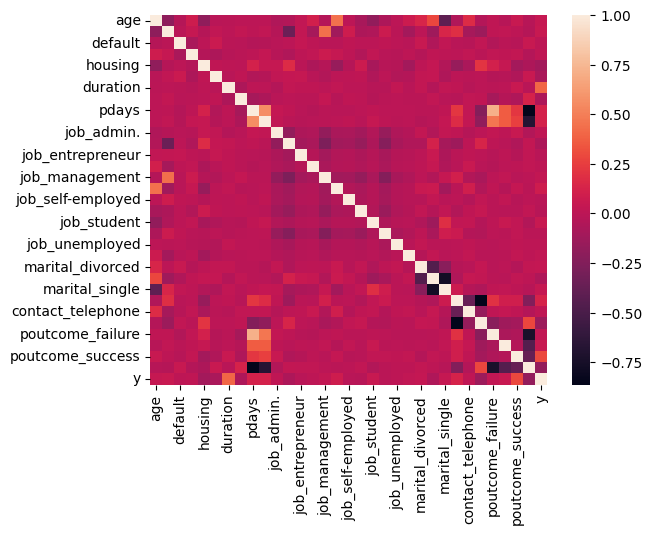

In [37]:
matriz_corr = pd.concat((x_train, y_train), axis=1).corr()
sns.heatmap(matriz_corr)

In [38]:
imp_corr = pd.concat((x_train, y_train), axis=1).corr()['y'][:-1]
imp_corr = imp_corr.abs().sort_values(ascending=False)
imp_corr

duration             0.396267
poutcome_success     0.292662
poutcome_unknown     0.174216
contact_unknown      0.140566
contact_cellular     0.126070
previous             0.117628
pdays                0.115149
housing              0.112570
loan                 0.080508
job_retired          0.076036
job_blue-collar      0.065732
campaign             0.064989
marital_married      0.060858
poutcome_other       0.053661
job_student          0.053014
education            0.047972
age                  0.044644
marital_single       0.040482
marital_divorced     0.036601
job_management       0.024960
job_unknown          0.024656
job_services         0.022380
poutcome_failure     0.020273
balance              0.016291
job_admin.           0.016234
job_entrepreneur     0.014884
job_self-employed    0.014282
contact_telephone    0.013328
job_technician       0.009206
default              0.005623
job_unemployed       0.003611
job_housemaid        0.003510
Name: y, dtype: float64

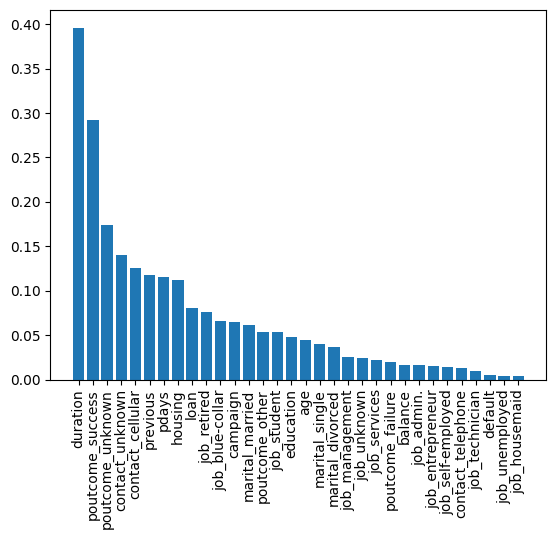

In [39]:
plt.bar(imp_corr.index, imp_corr)
plt.xticks(rotation=90)
plt.show()

In [84]:
lista_atributos = np.array(imp_corr.index[:3])
lista_atributos

array(['duration', 'poutcome_success', 'poutcome_unknown'], dtype=object)

In [85]:
knn_corr = KNeighborsClassifier(n_neighbors=5)
knn_corr.fit(x_train[lista_atributos], y_train)
knn_corr.score(x_test[lista_atributos], y_test)

0.9005524861878453

In [86]:
# Comparamos con el base con todos los atributos y vemos que incluso ganamos un 1% de accuracy
knn.score(x_test, y_test)

0.8895027624309392

## Importancia por Permutación

In [43]:
from sklearn.inspection import permutation_importance

Calculamos la importancia de características por permutación utilizando
la función disponible en sklearn

In [45]:
# Tarda un rato (costoso computacionalmente para modelos lentos)
imp_perm = permutation_importance(knn, x_train, y_train, n_repeats=10)

In [54]:
imp_df = pd.DataFrame({'ft': x_train.columns,
                       'mean': imp_perm.importances_mean,
                       'std': imp_perm.importances_std
                      })
imp_df.sort_values('mean', ascending=False, inplace=True)
imp_df.head()

,ft,mean,std
30,poutcome_success,0.020658,0.001805
6,duration,0.019386,0.001689
26,contact_telephone,0.003761,0.001058
8,pdays,0.003485,0.000633
22,marital_divorced,0.003319,0.001120


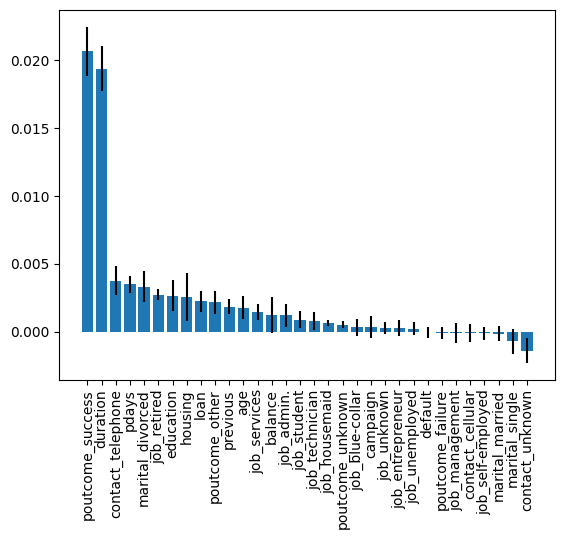

In [58]:
plt.bar(range(imp_df.shape[0]), imp_df["mean"], yerr=imp_df["std"], tick_label=imp_df["ft"])
plt.xticks(rotation=90)
plt.show()

In [87]:
lista_atributos = np.array(imp_df["ft"][:3])
lista_atributos

array(['poutcome_success', 'duration', 'contact_telephone'], dtype=object)

In [88]:
knn_perm = KNeighborsClassifier(n_neighbors=5)
knn_perm.fit(x_train[lista_atributos], y_train)
knn_perm.score(x_test[lista_atributos], y_test)

0.8994475138121547

In [89]:
# Comparamos con el base con todos los atributos y vemos que incluso ganamos un 1% de accuracy
knn.score(x_test, y_test)

0.8895027624309392

## ¿Por qué?

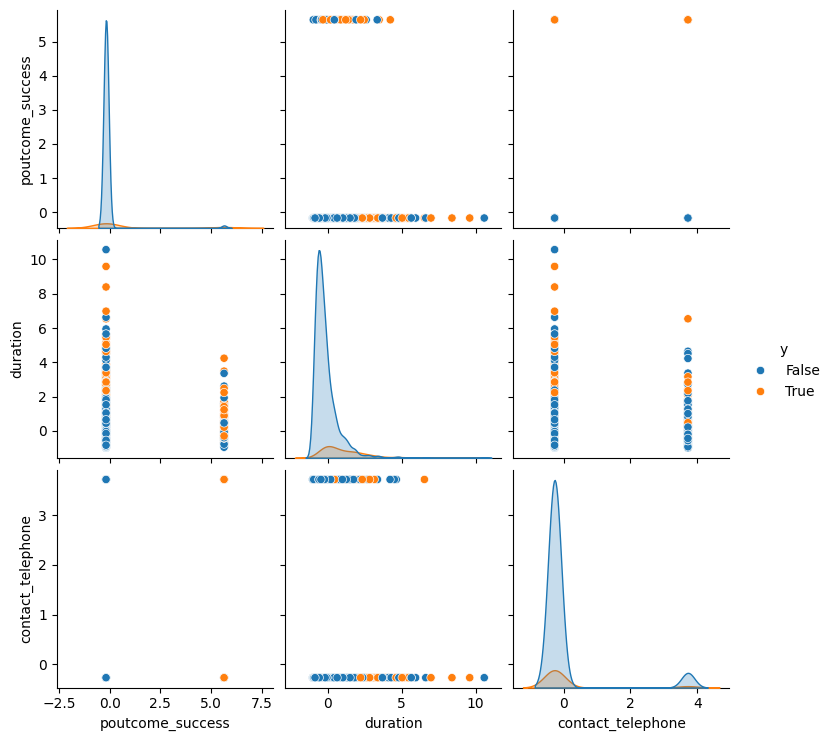

In [90]:
data = pd.concat((x_train[lista_atributos], y_train), axis=1)
sns.pairplot(data, hue="y")

In [91]:
x_train[lista_atributos]

,poutcome_success,duration,contact_telephone
3108,-0.177105,-0.931124,-0.268962
984,5.644813,-0.161198,-0.268962
2255,-0.177105,-0.701295,-0.268962
612,-0.177105,-0.007979,-0.268962
2475,-0.177105,-0.004148,-0.268962
...,...,...,...
1607,-0.177105,-0.697465,-0.268962
3915,-0.177105,-0.835362,-0.268962
1428,-0.177105,-0.161198,-0.268962
4367,-0.177105,-0.555737,-0.268962


**PREGUNTA:** ¿Qué está mal?

In [95]:
# LAS CLASES ESTAN DESBALANCEADAS!!!
# Si predices todo False tienes un 0.88 de accuracy
np.mean(y_train == False)

0.8808075221238938